### All Improvements: Loss $\mathcal L_\mathrm{geo,unc} + \mathcal L_\mathrm{acc}$, dataset $\mathcal S|_{b = 3}$

In [1]:
CHOSEN_ARRAY_B=3

In [2]:
import multiprocessing as mp
import numpy as np

In [3]:
def objective_process(result_queue):
    import matplotlib.pyplot as plt
    import tensorflow as tf
    import numpy as np
    
    import DissimilarityMetrics
    import ChannelChartingCore
    import Evaluation

    import dichasus_cf0x

    print("Loading Dataset...")
    groundtruth_positions = []
    csi_time_domain_onearray = []
    timestamps = []
    
    for csi, pos, time in dichasus_cf0x.singlearray_trainingsets[CHOSEN_ARRAY_B-1].batch(1000):
        csi_time_domain_onearray.append(csi.numpy())
        groundtruth_positions.append(pos.numpy())
        timestamps.append(time.numpy())
    
    csi_time_domain_onearray = np.concatenate(csi_time_domain_onearray)
    groundtruth_positions = np.concatenate(groundtruth_positions)
    timestamps = np.concatenate(timestamps)
    
    MEASUREMENT_INTERVAL = 0.048
    timestamps = timestamps - timestamps[0]
    timestamps = np.round(timestamps / MEASUREMENT_INTERVAL) * MEASUREMENT_INTERVAL    

    Evaluation.plot_colorized(groundtruth_positions, groundtruth_positions, title="Ground Truth Positions")

    def mean_variance_from_delta_adp(delta_adp):
        mean = np.where(delta_adp < 1, 0,
               np.where(np.logical_and(delta_adp >= 1, delta_adp < 3), 0.01 * delta_adp + 0.01, 
               np.where(delta_adp > 3, np.inf, np.nan)))
    
        variance = np.where(delta_adp < 1, 0.0001,
           np.where(np.logical_and(delta_adp >= 1, delta_adp < 3), 0.0002 + 0.00005 * delta_adp, 
           np.where(delta_adp > 3, 10000, np.nan)))
    
        return mean, variance

    adp_metric = DissimilarityMetrics.ADPDissimilarityMetric(csi_time_domain_onearray, mean_variance_from_delta_adp)    

    # For the single-antenna setup we assume a lower variance in the velocity model so that
    # the channel charting algorithm relies more on velocity information.
    velocity_mean = 0.235
    velocity_variance = 0.0015
    
    # Make worst-case assumption of perfectly correlated velocities. This maximizes the variance.
    velocity_metric = DissimilarityMetrics.VelocityDissimilarityMetric(velocity_mean, velocity_variance, True, timestamps)

    GDM = ChannelChartingCore.GaussianDissimilarityModel([adp_metric, velocity_metric], enable_path_contraction = False)
    GDM.generate_short_paths(realization_count = 8)

    MIN_BATCH_SIZE = 2500
    MAX_BATCH_SIZE = 3500
    LEARNING_RATE_INITIAL = 2e-2
    LEARNING_RATE_FINAL = 1e-2
    MAX_HOPLENGTH = 3.0
    MIN_HOPLENGTH = 0.5
    TRAINING_BATCHES = 3600
    ACCELERATION_MEAN = 0.0
    ACCELERATION_VARIANCE = 0.85
    ACCELERATION_WEIGHT = 0.04

    plot_callback = None # Evaluation.PlotChartCallback(groundtruth_positions, csi_time_domain_onearray.shape[0], max_hops = MAX_PATHHOPS)
    cc = ChannelChartingCore.ChannelChart(GDM, csi_time_domain_onearray, timestamps, min_batch_size = MIN_BATCH_SIZE, max_batch_size = MAX_BATCH_SIZE, learning_rate_initial = LEARNING_RATE_INITIAL, learning_rate_final = LEARNING_RATE_FINAL, max_hoplength = MAX_HOPLENGTH, min_hoplength = MIN_HOPLENGTH, randomize_pathhops = True, training_batches = TRAINING_BATCHES, plot_callback = plot_callback, acceleration_mean = ACCELERATION_MEAN, acceleration_variance = ACCELERATION_VARIANCE, acceleration_weight = ACCELERATION_WEIGHT)

    channel_chart_positions = cc.predict(csi_time_domain_onearray)
    ct, tw, ks = Evaluation.ct_tw_ks_on_subset(groundtruth_positions, channel_chart_positions)
    print(f"CT: {ct:.4f}\nTW: {tw:.4f}\nKS: {ks:.4f}")

    channel_chart_positions_transformed, errorvectors, errors, mae, cep = Evaluation.mean_absolute_error_transformed(groundtruth_positions, channel_chart_positions)
    Evaluation.plot_colorized(channel_chart_positions_transformed, groundtruth_positions, title = "CC After Affine Transform")
    drms = np.sqrt(np.mean(np.square(errors)))
    
    print(f"MAE: {mae:.4f}\nCEP: {cep:.4f}\nDRMS: {drms:.4f}")
    loss = cc.history.history["loss"][-1]
    print(cc.history.history["loss"])
    print(f"Loss: {loss:.4f}")
    
    result_queue.put((mae, cep, drms, loss))

In [4]:
maes = []
ceps = []
drmss = []
losses = []

result_queue = mp.Queue()

2024-12-04 17:28:04.788291: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 17:28:05.578256: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-04 17:28:06.820782: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-04 17:28:06.874644: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. 

Loading Dataset...


2024-12-04 17:28:31.465543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


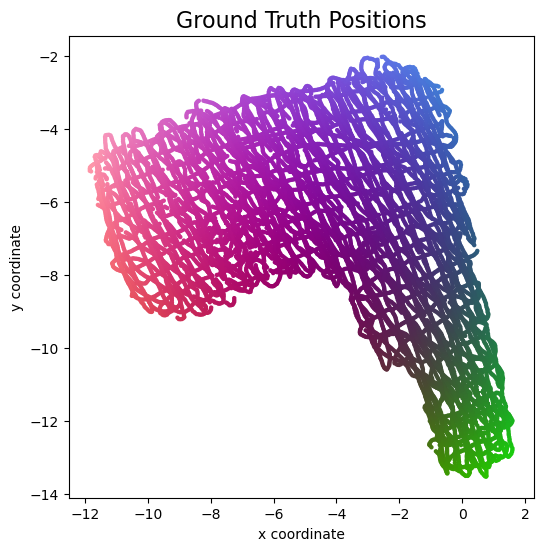

  0%|          | 0/8 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/104255000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/5000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/104255000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/5000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

Generating dissimilarity realizations...


  0%|          | 0/2 [00:00<?, ?it/s]

Choosing smallest dissimilarity realization pair-wise...
Running shortest path algorithm...


Computing Shortest Paths:   0%|          | 0/104255000 [00:00<?, ?it/s]

Preparing Dijkstra Inputs:   0%|          | 0/5000 [00:00<?, ?it/s]

Starting Processes:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
for i in range(30):
    p = mp.Process(target=objective_process, args=(result_queue,))
    p.start()
    p.join()

    mae, cep, drms, loss = result_queue.get()
    maes.append(mae)
    ceps.append(cep)
    drmss.append(drms)
    losses.append(loss)

In [16]:
maes = np.asarray(maes)
ceps = np.asarray(ceps)
drmss = np.asarray(drmss)
losses = np.asarray(losses)

In [17]:
import matplotlib.pyplot as plt

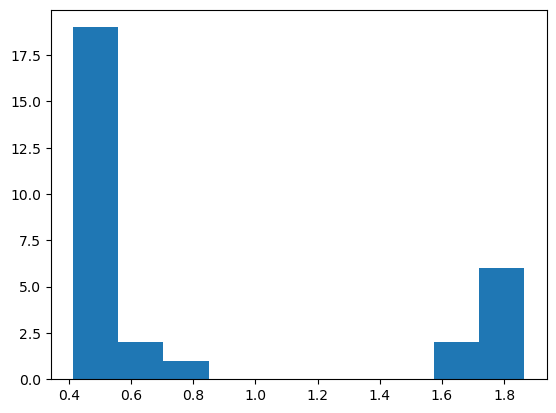

In [18]:
plt.hist(maes)
plt.show()

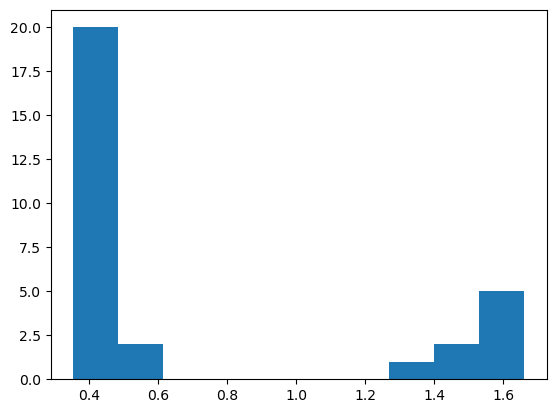

In [19]:
plt.hist(ceps)
plt.show()

In [20]:
print(f"Mean MAE: {np.mean(maes):.3f}")
print(f"Mean CEP: {np.mean(ceps):.3f}")

Mean MAE: 0.823
Mean CEP: 0.705


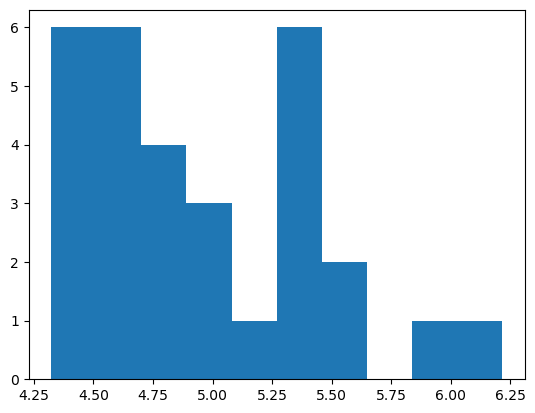

In [21]:
plt.hist(losses)
plt.show()

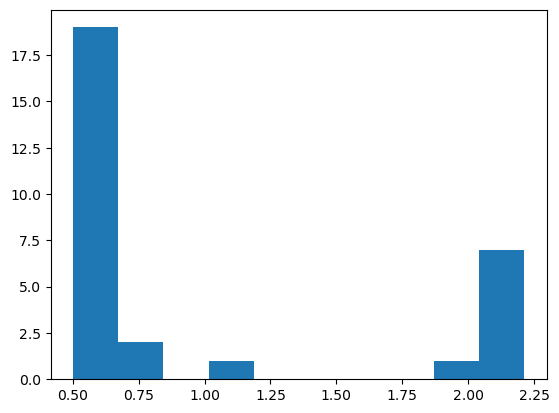

In [22]:
plt.hist(drmss)
plt.show()

In [23]:
print(f"Mean MAE : {np.mean(maes):.3f}")
print(f"Mean CEP : {np.mean(ceps):.3f}")
print(f"Mean DRMS: {np.mean(drmss):.3f}")

Mean MAE : 0.823
Mean CEP : 0.705
Mean DRMS: 0.994


In [24]:
loss_sort_order = np.argsort(losses)

In [25]:
print("Results for 20 training passes with lowest loss")
print(f"Mean MAE : {np.mean(maes[loss_sort_order][:20]):.3f}")
print(f"Mean CEP : {np.mean(ceps[loss_sort_order][:20]):.3f}")
print(f"Mean DRMS: {np.mean(drmss[loss_sort_order][:20]):.3f}")

Results for 20 training passes with lowest loss
Mean MAE : 0.479
Mean CEP : 0.405
Mean DRMS: 0.585
